# Tiny Conv Diffusion with Matern32 GP Noise (No Time Embedding)

Lightweight diffusion on MNIST using the TinyConvDenoiser and Matern 3/2 GP noise instead of i.i.d. Gaussian noise.

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from realistica import (
    NoiseScheduler,
    TinyConvDenoiser,
    ImageGPNoiseSampler,
    sample_gp_noise_for_images,
)

## Config

In [13]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Device: {device}")

config = {
    'batch_size': 128,
    'num_epochs': 20,
    'lr': 1e-4,
    'num_timesteps': 1000,
    'beta_start': 0.0001,
    'beta_end': 0.02,
    'use_gp_noise': True,
    'gp_lengthscale': 0.15,
    'gp_num_features': 512,
}

os.makedirs('outputs/mnist_conv_matern32/samples', exist_ok=True)
os.makedirs('outputs/mnist_conv_matern32/checkpoints', exist_ok=True)

Device: mps


## Load Data

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)

print(f"Dataset: {len(train_dataset)} images")

Dataset: 60000 images


## Model + GP Noise Setup

In [15]:
# Training control
LOAD_PRETRAINED = True  # Set to False to train from scratch
PRETRAINED_PATH = 'outputs/mnist_conv_simple/checkpoint.pt'  # Pretrained conv model
LOAD_MODEL = False  # Set to True to continue training this matern32 model

# Noise scheduler
noise_scheduler = NoiseScheduler(
    num_timesteps=config['num_timesteps'],
    beta_start=config['beta_start'],
    beta_end=config['beta_end'],
    schedule_type='linear',
    device=device
)

# GP noise sampler (reused across batches)
gp_noise_sampler = ImageGPNoiseSampler(
    height=28,
    width=28,
    lengthscale=config['gp_lengthscale'],
    variance=1.0,
    num_features=config['gp_num_features'],
    kernel_type='matern32',
    device=device
)

# Tiny conv model - NO time embedding!
model = TinyConvDenoiser().to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {num_params:,}")

# Transfer Learning: Load pretrained conv model first
checkpoint_path = 'outputs/mnist_conv_matern32/checkpoints/final_model.pth'
if LOAD_MODEL and os.path.exists(checkpoint_path):
    # Continue training existing matern32 model
    print(f"Loading matern32 model from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Handle both old format (nested dict) and new format (direct state_dict)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Matern32 model loaded!")
    else:
        model.load_state_dict(checkpoint)
        print("Matern32 model loaded!")
elif LOAD_PRETRAINED and os.path.exists(PRETRAINED_PATH):
    # Transfer learning from pretrained conv_simple model
    print(f"Transfer learning: Loading pretrained model from {PRETRAINED_PATH}")
    checkpoint = torch.load(PRETRAINED_PATH, map_location=device)
    
    # Handle both old format (nested dict) and new format (direct state_dict)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Pretrained weights loaded! Starting transfer learning...")
    else:
        model.load_state_dict(checkpoint)
        print("Pretrained weights loaded! Starting transfer learning...")
else:
    print("Training from scratch")

print(f"Using Matern32 GP noise with lengthscale={config['gp_lengthscale']}")

Parameters: 82,945
Transfer learning: Loading pretrained model from outputs/mnist_conv_simple/checkpoint.pt
Pretrained weights loaded! Starting transfer learning...
Using Matern32 GP noise with lengthscale=0.15


## GP Noise vs Gaussian

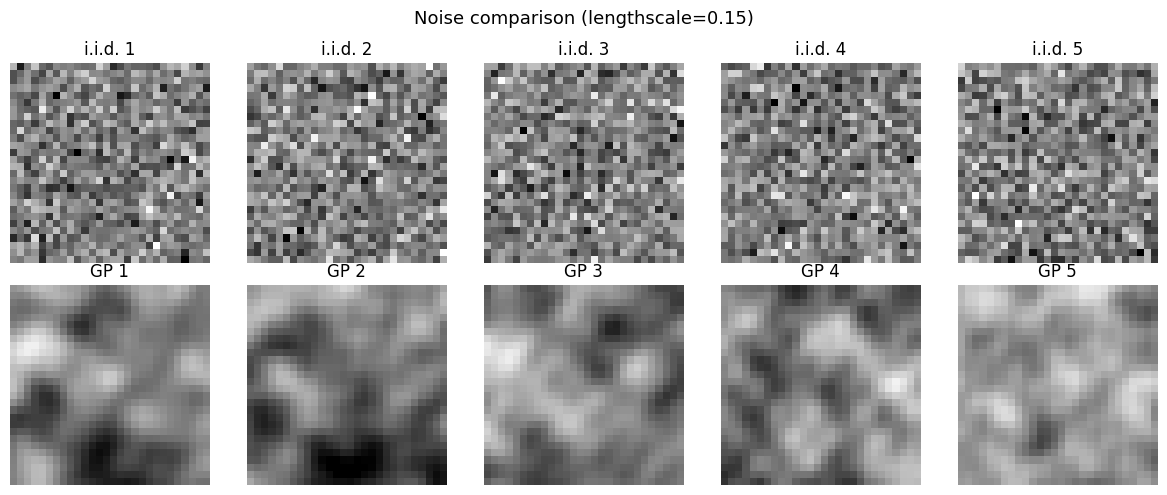

In [16]:
# Compare a few noise draws to see the spatial correlation
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

regular_noise = torch.randn(5, 1, 28, 28)
for i in range(5):
    axes[0, i].imshow(regular_noise[i, 0].numpy(), cmap='gray', vmin=-3, vmax=3)
    axes[0, i].set_title(f'i.i.d. {i+1}')
    axes[0, i].axis('off')

# GP noise with Matern32
gp_noise = sample_gp_noise_for_images(
    batch_size=5,
    channels=1,
    height=28,
    width=28,
    lengthscale=config['gp_lengthscale'],
    num_features=config['gp_num_features'],
    kernel_type='matern32',
    device=device
)

for i in range(5):
    axes[1, i].imshow(gp_noise[i, 0].cpu().numpy(), cmap='gray', vmin=-3, vmax=3)
    axes[1, i].set_title(f'GP {i+1}')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Gaussian', fontsize=11)
axes[1, 0].set_ylabel('Matern32', fontsize=11)
plt.suptitle(f'Noise comparison (lengthscale={config["gp_lengthscale"]})', fontsize=13)
plt.tight_layout()
plt.show()

## Training with GP Noise

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.MSELoss()

losses = []

for epoch in range(config['num_epochs']):
    model.train()
    epoch_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
    for images, _ in pbar:
        images = images.to(device)
        batch_size = images.shape[0]
        
        # Random timesteps
        t = noise_scheduler.sample_timesteps(batch_size)
        
        # Add GP noise instead of i.i.d. Gaussian
        if config['use_gp_noise']:
            noisy_images, noise = noise_scheduler.add_gp_noise(
                images, t, gp_noise_sampler=gp_noise_sampler
            )
        else:
            noisy_images, noise = noise_scheduler.add_noise(images, t)
        
        # Predict noise (model ignores t even though we pass it)
        pred_noise = model(noisy_images, t)
        
        # Loss
        loss = criterion(pred_noise, noise)
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    print(f"Epoch {epoch+1} - Avg Loss: {epoch_loss/len(train_loader):.6f}")

# Optional: save final weights
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
}, 'outputs/mnist_conv_matern32/checkpoints/final_model.pth')
print("Training complete!")

Epoch 1/20: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s, loss=0.0292]


Epoch 1 - Avg Loss: 0.029418


Epoch 2/20: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s, loss=0.0311]


Epoch 2 - Avg Loss: 0.029276


Epoch 3/20: 100%|██████████| 469/469 [00:21<00:00, 21.34it/s, loss=0.0301]


Epoch 3 - Avg Loss: 0.028986


Epoch 4/20: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s, loss=0.0299]


Epoch 4 - Avg Loss: 0.028755


Epoch 5/20: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s, loss=0.0286]


Epoch 5 - Avg Loss: 0.028517


Epoch 6/20: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s, loss=0.0263]


Epoch 6 - Avg Loss: 0.028600


Epoch 7/20: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s, loss=0.0267]


Epoch 7 - Avg Loss: 0.028169


Epoch 8/20: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s, loss=0.0301]


Epoch 8 - Avg Loss: 0.028174


Epoch 9/20: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s, loss=0.0298]


Epoch 9 - Avg Loss: 0.028038


Epoch 10/20: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s, loss=0.0273]


Epoch 10 - Avg Loss: 0.027646


Epoch 11/20: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s, loss=0.0379]


Epoch 11 - Avg Loss: 0.027653


Epoch 12/20: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s, loss=0.0234]


Epoch 12 - Avg Loss: 0.027521


Epoch 13/20: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s, loss=0.0255]


Epoch 13 - Avg Loss: 0.027493


Epoch 14/20: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s, loss=0.0304]


Epoch 14 - Avg Loss: 0.027223


Epoch 15/20: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s, loss=0.0254]


Epoch 15 - Avg Loss: 0.027108


Epoch 16/20: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s, loss=0.0311]


Epoch 16 - Avg Loss: 0.026837


Epoch 17/20: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s, loss=0.0229]


Epoch 17 - Avg Loss: 0.026659


Epoch 18/20: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s, loss=0.0295]


Epoch 18 - Avg Loss: 0.026678


Epoch 19/20: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s, loss=0.0300]


Epoch 19 - Avg Loss: 0.026669


Epoch 20/20: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s, loss=0.0220]

Epoch 20 - Avg Loss: 0.026251
Training complete!


## Sample with GP Noise

Sampling: 1000it [00:16, 60.78it/s]


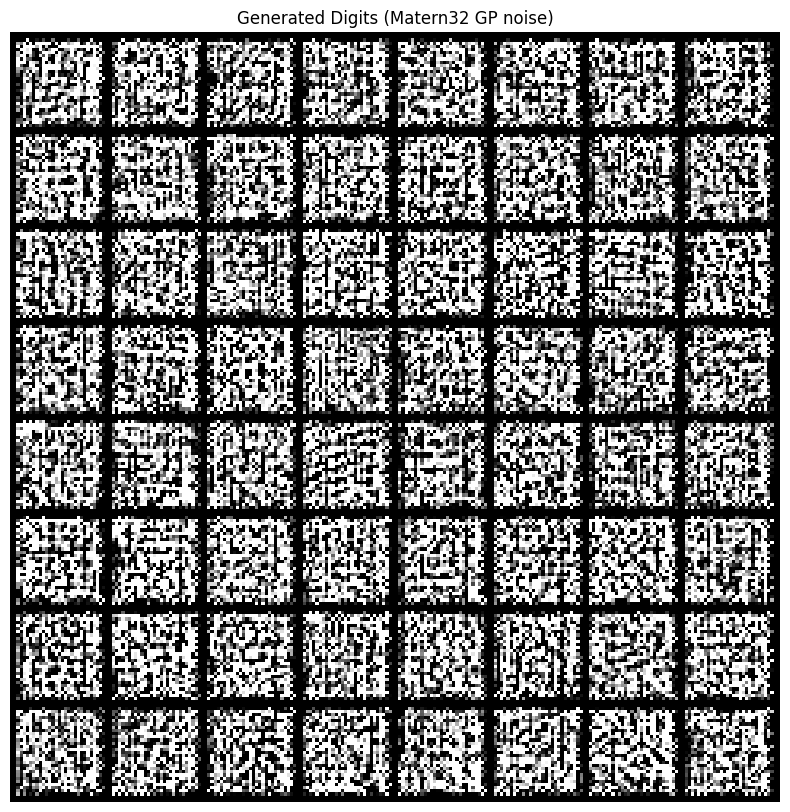

In [26]:
@torch.no_grad()
def sample(num_samples=64):
    model.eval()
    
    # Start from GP noise instead of white noise
    if config['use_gp_noise']:
        x = gp_noise_sampler.sample(num_samples, 1)
    else:
        x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    # Denoise
    for t in tqdm(reversed(range(config['num_timesteps'])), desc='Sampling'):
        t_batch = torch.tensor([t] * num_samples, device=device)
        
        # Predict noise (model ignores t)
        pred_noise = model(x, t_batch)
        
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        
        if t > 0:
            if config['use_gp_noise']:
                noise = gp_noise_sampler.sample(num_samples, 1)
            else:
                noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        
        # DDPM step
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * pred_noise)
        x = x + torch.sqrt(beta) * noise
    
    return x

# Generate
samples = sample(64)

# Show
grid = make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Generated Digits (Matern32 GP noise)')
plt.savefig('outputs/mnist_conv_matern32/samples/generated.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualize Denoising Steps

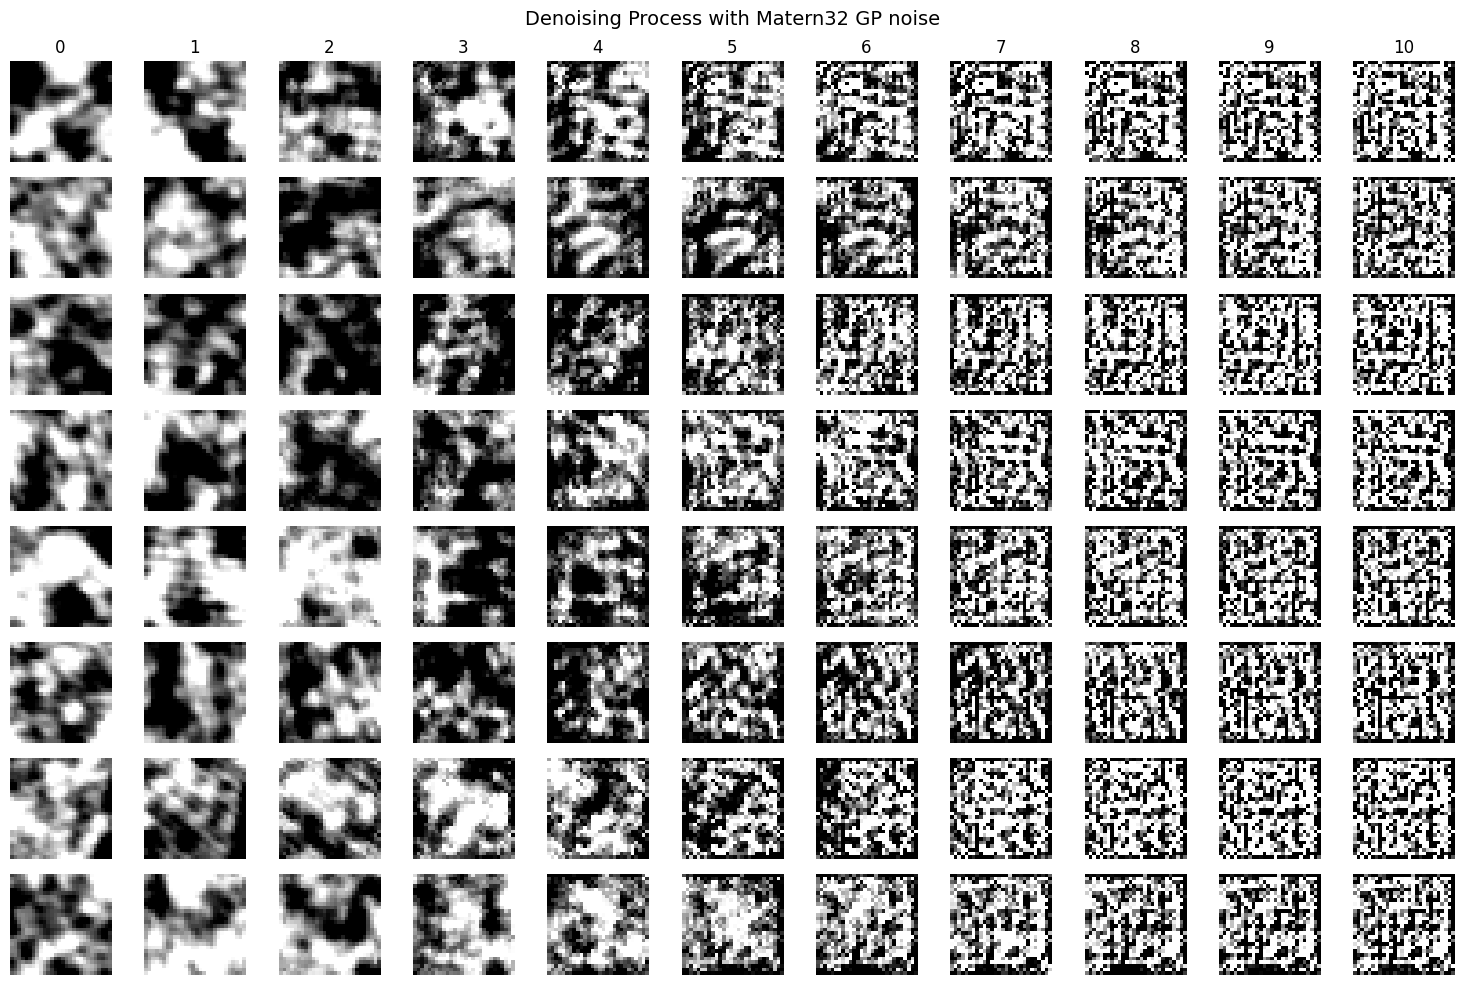

In [27]:
@torch.no_grad()
def sample_steps(num_samples=8, steps_to_show=10):
    model.eval()
    if config['use_gp_noise']:
        x = gp_noise_sampler.sample(num_samples, 1)
    else:
        x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    timesteps = list(reversed(range(config['num_timesteps'])))
    interval = max(1, len(timesteps) // steps_to_show)
    saved = []
    
    for i, t in enumerate(timesteps):
        if i % interval == 0 or i == len(timesteps) - 1:
            saved.append(x.detach().cpu().clone())
        
        t_batch = torch.tensor([t] * num_samples, device=device)
        pred_noise = model(x, t_batch)
        
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        if t > 0:
            if config['use_gp_noise']:
                noise = gp_noise_sampler.sample(num_samples, 1)
            else:
                noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * pred_noise)
        x = x + torch.sqrt(beta) * noise
    
    return saved

steps = sample_steps(8, 10)

# Plot
fig, axes = plt.subplots(8, len(steps), figsize=(15, 10))
for i in range(8):
    for j, imgs in enumerate(steps):
        axes[i, j].imshow(imgs[i, 0].numpy(), cmap='gray', vmin=-1, vmax=1)
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(f'{j}')

plt.suptitle('Denoising Process with Matern32 GP noise', fontsize=14)
plt.tight_layout()
plt.show()